# <b>Data Mining Challenge 2020</b>

## <b>Team</b>
* Tommaso Fioravanti - 105xxxxx(Student-ID)
* Matteo Moreschini - 105xxxxx(Student-ID)
* Alessio Introito Russo - 105xxxxx(Student-ID)
* Davide Salaorni - 10526800
---

# <b>1. Introduction</b>
The project is based on sales forecasting. Indeed, we have been provided with aggregated weekly-recorded information for different products (_SKU_) throughout a 3  years time window, from December 2016 to December 2019. We are asked to forecast the weekly sales regarding 12 of the 43 products in the dataset. <br>
The metric that we are going to use to estimate the goodness of our predictions is the Mean Average Percentage Error (_MAPE_).

Here a quick glance to the dataset and to the time series:

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sys
sys.path.append("../")

train = pd.read_csv("../dataset/original/train.csv")
test = pd.read_csv("../dataset/original/x_test.csv")

from preprocessing.preprocessing import convert_date 

convert_date(train.copy()).head()

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target
0,2016-12-10,2689,SINGLE,395.41,BRAND1,1.16,NaN,NaN,NaN,0,24175.0
1,2016-12-17,2689,SINGLE,395.41,BRAND1,1.15,1.0,17.676112,24175.0,0,23521.0
2,2016-12-24,2689,SINGLE,395.41,BRAND1,1.16,1.0,24.482803,23521.0,0,22075.0
3,2016-12-31,2689,SINGLE,395.41,BRAND1,1.16,0.0,19.410646,22075.0,0,16492.0
4,2017-01-07,2689,SINGLE,395.41,BRAND1,1.16,0.0,29.812030,16492.0,0,25971.0


---
# <b>2. Data Preprocessing</b>
First of all, we have decided how to deal with the NaNs in the train and we have chosen to impute them. <br>
Moreover, we have found useful to convert the values of **_sales w-1_** and **_target_** to the logarithm to smooth the predictions ... (?)  
Furthermore, we have attached to the whole dataframe the column **_real_target_** with the target that we have to predict for that specific week.

## _TODO: aggiungere qualcos'altro_

In [11]:
from preprocessing.preprocessing import preprocessing
df_preprocessed = preprocessing(train, test)
df_preprocessed.head()

,Date,sku,pack,size (GM),brand,price,POS_exposed w-1,volume_on_promo w-1,sales w-1,scope,target,real_target
0,2016-12-10,144,0,114.23,1,2.18,NaN,NaN,10.497091,1,10.845855,51320.0
1,2016-12-17,144,0,114.23,1,2.00,45.0,100.000000,10.845855,1,11.103934,66431.0
2,2016-12-24,144,0,114.23,1,2.05,17.0,100.000000,11.103934,1,10.950842,57001.0
3,2016-12-31,144,0,114.23,1,3.00,2.0,100.000000,10.950842,1,9.619333,15052.0
4,2017-01-07,144,0,114.23,1,2.99,2.0,28.534193,9.619333,1,9.999570,22016.0


---
# <b>3. Baseline</b>
Our baseline model is a very simple model, lacking of every feature and immediately computed to better understand the richness of the dataset.

In [12]:
# Baseline model here

---
# <b>4. In Depth Analysis</b>

Exploring the dataset, we have carried out some analysis concerning different topics:

#### **1. _Trend and seasonality:_** to understand the shape of different time series and their stationarity;
#### **2. _Autocorrelation:_** to see if each time series is dependent from the past;
#### **3. _Features Correlation:_** to discover some correlations between attributes in the dataset;
#### **4. _Clusters Analysis:_** to group some time series which have a common behaviour.

# 4.1 Trend and Seasonality
As we can see from the following plots there are no a specific seasonality among the months of a year and in general there is no a specific trend.

Text(0, 0.5, 'Target')

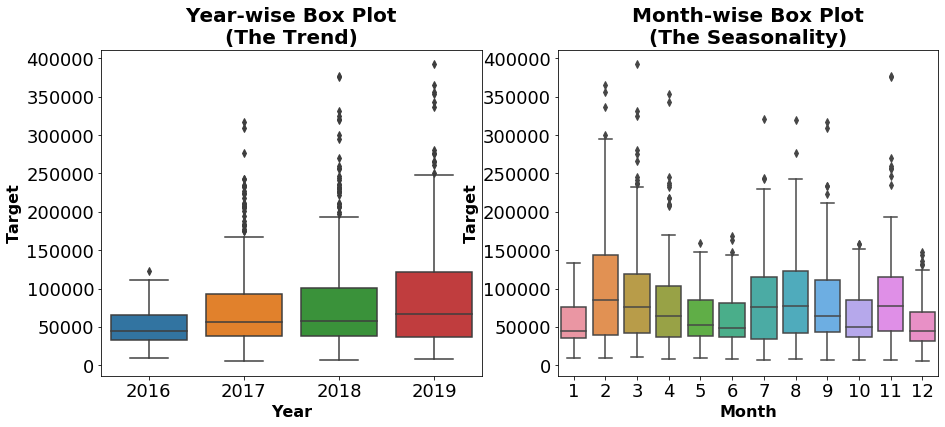

In [14]:
from preprocessing.preprocessing import _split_date

date_split_train = _split_date(train)
date_split_train = date_split_train[date_split_train.scope == 1]

variable = 'target'
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

sns.boxplot(date_split_train['year'], date_split_train[variable], ax=ax[0])
ax[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax[0].set_xlabel('Year', fontsize=16, fontdict=dict(weight='bold'))
ax[0].set_ylabel('Target', fontsize=16, fontdict=dict(weight='bold'))

sns.boxplot(date_split_train['month'], date_split_train[variable], ax=ax[1])
ax[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax[1].set_xlabel('Month', fontsize=16, fontdict=dict(weight='bold'))
ax[1].set_ylabel('Target', fontsize=16, fontdict=dict(weight='bold'))


# 4.3 Features Correlation

C:\Users\david\anaconda3\lib\site-packages\seaborn\axisgrid.py:2079: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


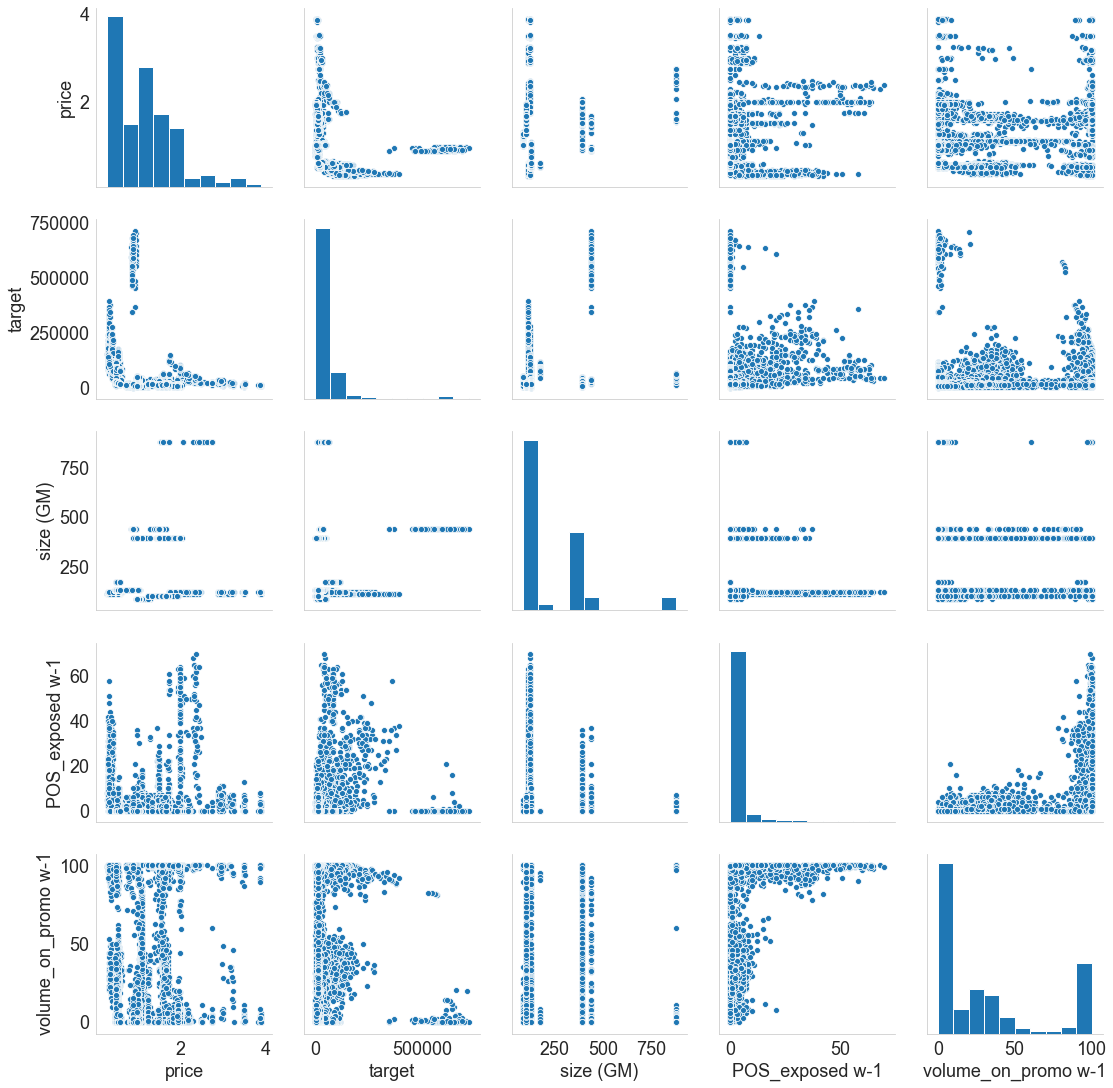

In [16]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(train[['price', 'target', 'pack', 'brand', 'size (GM)', 'POS_exposed w-1', 'volume_on_promo w-1']], size=3)

# 4.4 Hierarchical Clustering

We load all the necessary libraries to perform hierarchical clustering.

In [5]:
df = pd.concat([train, test],sort=False)
df = convert_date(df)
df = df.sort_values(['sku','Date'])

train = df[~df.target.isna()]
test = df[df.target.isna()]

from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy import stats

Then we group the timeseries by sku and we compute the distance matrix for the hierarchical clustering using the <i>linkage</i> function. 

The distance measure used for the clustering is the <i>correlation</i> between each pairs of timeseries.


In [6]:
series1=[]
ix=[]
for i, s in enumerate(set(train.sku)):
    ix.append(s)
    series1.append(((train[train.sku==s].target).values))
series1=np.asarray(series1)
z1= linkage(series1,'single',metric='correlation')


Then we plot the resulting dendogram.

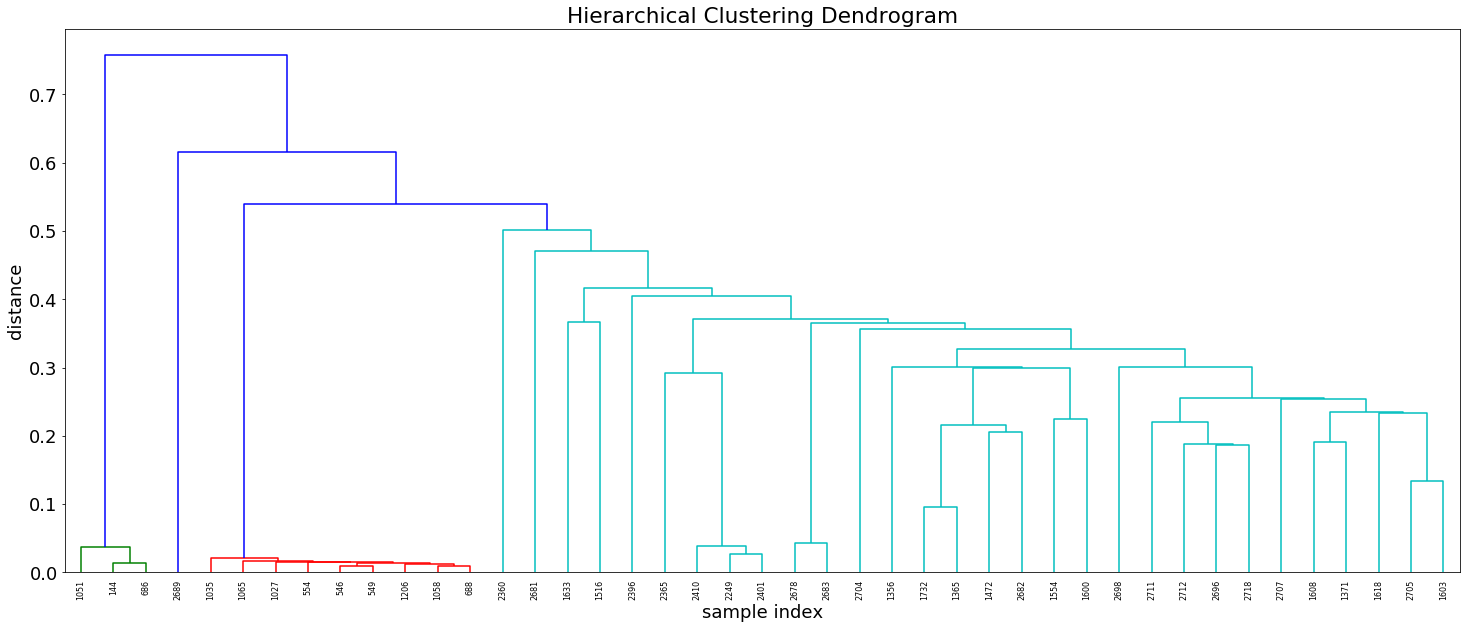

In [7]:
plt.figure(figsize=(25, 10))
font = {'family' : 'sans', 'size'   : 18}
plt.rc('font', **font)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(z1, 
    leaf_rotation=90.,  
    leaf_font_size=8.,  
    labels=ix
)
plt.show()

Using the <i>Knee and Elbow</i> analysis (see <i> Clustering.ipynb</i> for the code) we have seen that a reasonable number of clusters is 4.


So we put our evidence on what happens with 4 clusters. 

Using the <i>fcluster</i> function we found the labels of the 4 clusters and we retrieve the corresponding sku, grouping the most correlated timeseries and creating a small dataframe.

In [8]:
label_corr=fcluster(z1,4,criterion='maxclust') #Cluster with "correlation distance measure"
sku=list((set(train.sku)))

data={'Label': label_corr,
     'Sku':sku}
df_cluster=pd.DataFrame(data, columns=['Label','Sku'])

#Timeseries of 1st cluster
cluster1=df_cluster[df_cluster.Label==1].Sku
cluster1=np.asarray(cluster1)
#2 cluster
cluster2=df_cluster[df_cluster.Label==2].Sku
cluster2=np.asarray(cluster2)
#3 cluster
cluster3=df_cluster[df_cluster.Label==3].Sku
cluster3=np.asarray(cluster3)
#4 cluster
cluster4=df_cluster[df_cluster.Label==4].Sku
cluster4=np.asarray(cluster4)

cluster=[cluster1,cluster2,cluster3,cluster4]



We plot the resulting clusters

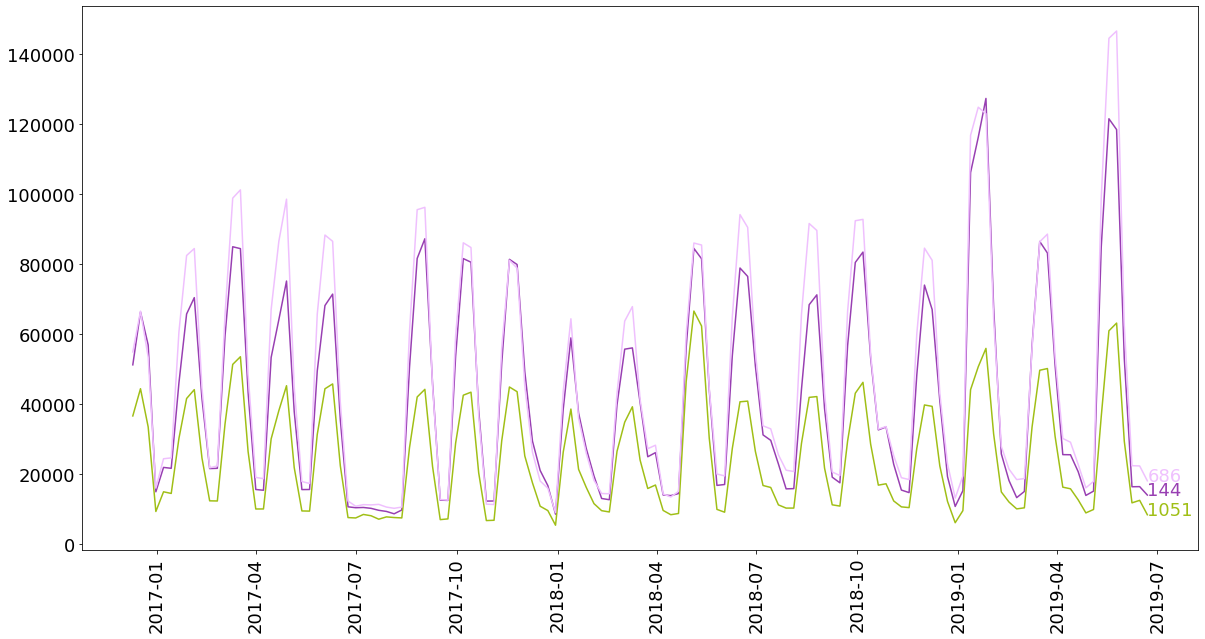

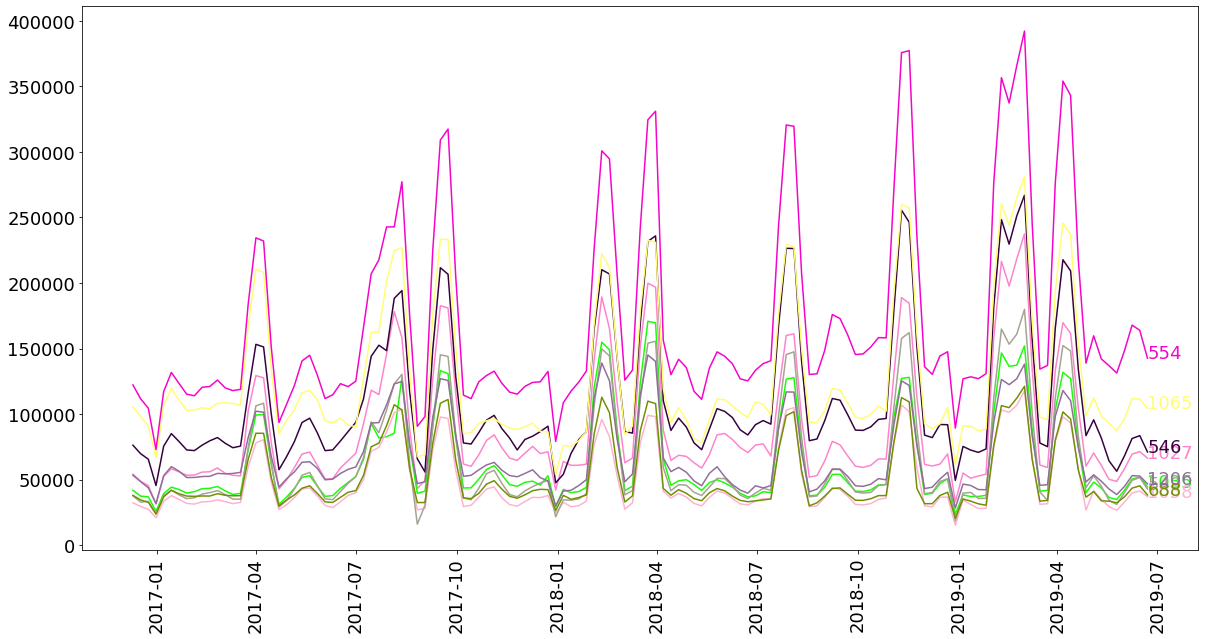

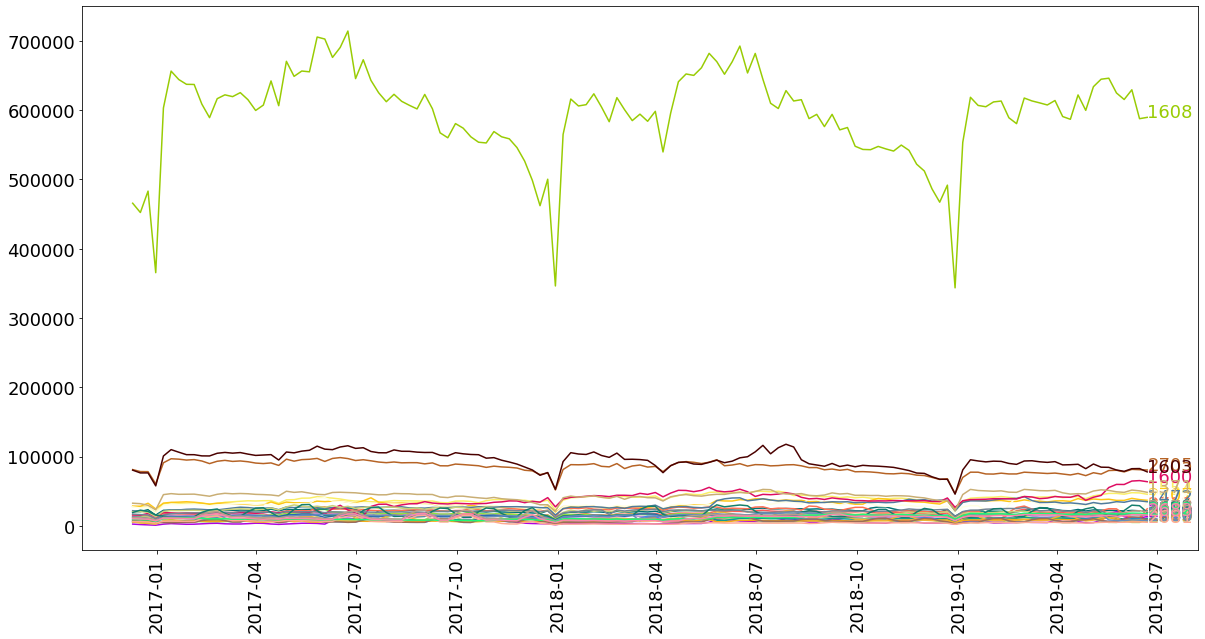

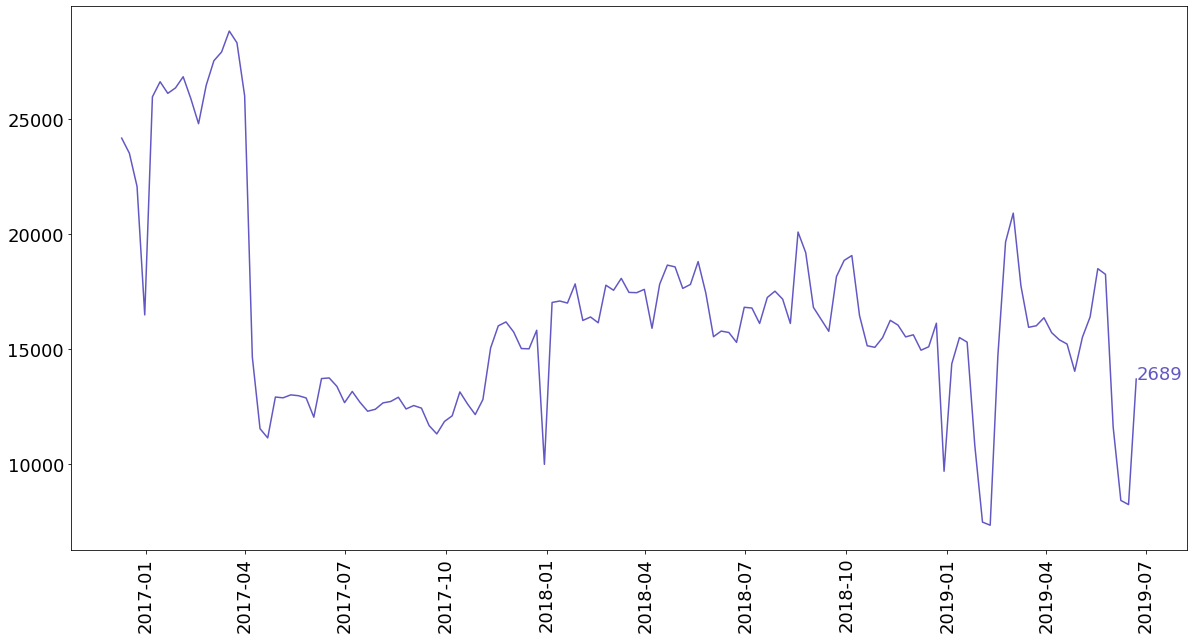

In [9]:
for j in cluster:
    
    mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(set(df.sku)), replace=False)
    plt.figure(figsize=(20,10))
    plt.xticks(rotation=90)
    for i in range(len(j)):
        plt.plot(train[train.sku==j[i]].Date, train[train.sku==j[i]].target,  color=mycolors[i])
        last_x, last_y = train[train.sku==j[i]].Date.values[-1], train[train.sku==j[i]].target.values[-1]
        plt.text(last_x, last_y, str(j[i]), color=mycolors[i])


We can see that the last cluster is composed only by one timeseries, so it could be labeled as outlier.


# Correlation HeatMap

Next we plot the correlation heatmap for the first two clusters (they will be used for training the models) to show that the timeseries inside the clusters are highly correlated

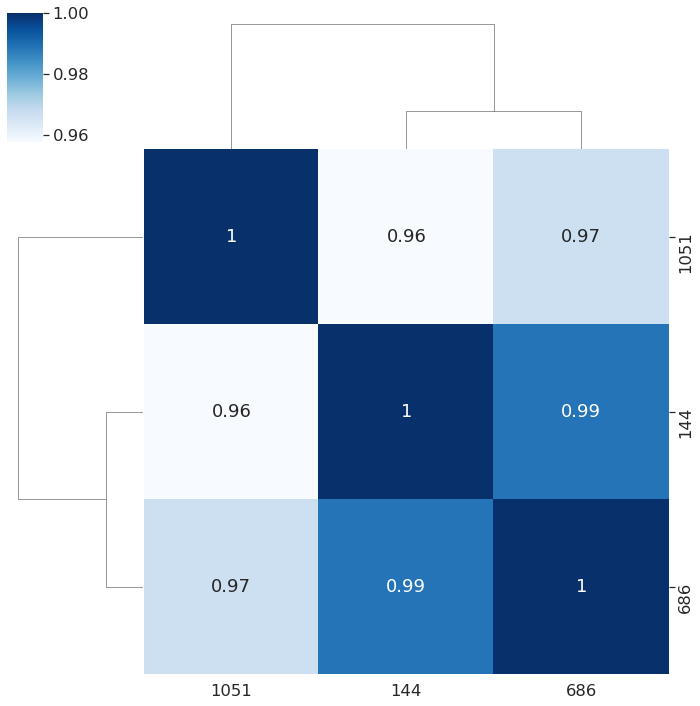

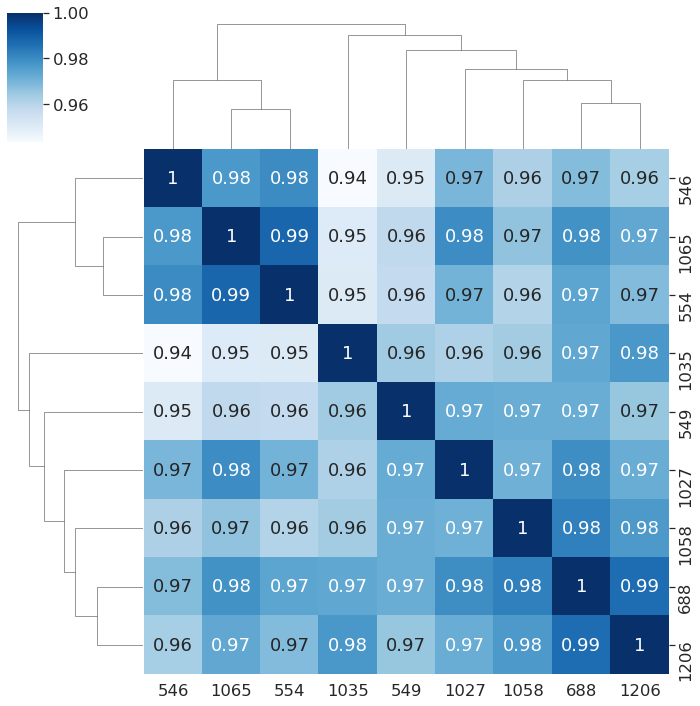

In [24]:

di={}

for i in cluster1:
    di.update({i:np.asarray((train[train.sku==i].target))})
df_clu1=pd.DataFrame(di).pct_change()

corr1=df_clu1.corr()
sns.set(font_scale=1.5)
sns.clustermap(corr1, cmap="Blues", annot=True);

di2={}
for i in cluster2:
    di2.update({i:np.asarray((train[train.sku==i].target))})
df_clu2=pd.DataFrame(di2).pct_change()

corr2=df_clu2.corr()
sns.set(font_scale=1.5)
sns.clustermap(corr2, cmap="Blues", annot=True);



# 5. Feature Engineering

# 6. Feature Selection

# 7. Model

# 8. Feature Importance

# 9. Model Comparison

# 10. Error Analysis

# 11. Future Steps (?)